In [1]:
import os
import hist
import uproot
import statistics
import numpy as np
import pandas as pd
import awkward as ak
import mplhep as hep
from hist import Hist
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['grid.color'] = "#CCCCCC"
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['figure.edgecolor'] = 'none'

In [2]:
input_dir = "/Users/deep/Downloads/cern/"
file_names = ["0_egps_upstreamtagger_8_1_gev.root", "1_egps_upstreamtagger_8_1_gev.root", "2_egps_upstreamtagger_8_1_gev.root", "3_egps_upstreamtagger_8_1_gev.root","4_egps_upstreamtagger_8_1_gev.root", "5_egps_upstreamtagger_8_1_gev.root","6_egps_upstreamtagger_8_1_gev.root", "7_egps_upstreamtagger_8_1_gev.root", "8_egps_upstreamtagger_8_1_gev.root", "9_egps_upstreamtagger_8_1_gev.root", "10_egps_upstreamtagger_8_1_gev.root"]

In [3]:
file = uproot.open("/Users/deep/Downloads/cern/0_egps_upstreamtagger_8_1_gev.root") # open the file
if 'LDMX_Events;4' not in file.keys():
      print ("empty")

file.keys() 

['LDMX_Events;4', 'LDMX_Events;3', 'LDMX_Run;1']

In [4]:
events_arr = []  
for i in range(len(file_names)):
    file = uproot.open(f"{input_dir}/{file_names[i]}")  # Open the file
    if 'LDMX_Events;4' not in file.keys():
        events_arr.append("empty")
        print ("empty")
        continue
    ldmx_events = file['LDMX_Events']
    procName = "electron"
    events = ak.zip({
        "TargetScoringPlaneHits": ak.zip({
            "id": ldmx_events[f"TargetScoringPlaneHits_{procName}.energy_"].array(library='ak'),
            "layerID": ldmx_events[f"TargetScoringPlaneHits_{procName}.layerID_"].array(library='ak'),
            "px": ldmx_events[f"TargetScoringPlaneHits_{procName}.px_"].array(library='ak'),
            "py": ldmx_events[f"TargetScoringPlaneHits_{procName}.py_"].array(library='ak'),
            "pz": ldmx_events[f"TargetScoringPlaneHits_{procName}.pz_"].array(library='ak'),
            "x": ldmx_events[f"TargetScoringPlaneHits_{procName}.x_"].array(library='ak'),
            "y": ldmx_events[f"TargetScoringPlaneHits_{procName}.y_"].array(library='ak'),
            "z": ldmx_events[f"TargetScoringPlaneHits_{procName}.z_"].array(library='ak'),
            "pdgID": ldmx_events[f"TargetScoringPlaneHits_{procName}.pdgID_"].array(library='ak'),
            "trackID": ldmx_events[f"TargetScoringPlaneHits_{procName}.trackID_"].array(library='ak'),
        }),
        "EcalScoringPlaneHits": ak.zip({
            "layerID": ldmx_events[f"EcalScoringPlaneHits_{procName}.layerID_"].array(library='ak'),
            "px": ldmx_events[f"EcalScoringPlaneHits_{procName}.px_"].array(library='ak'),
            "py": ldmx_events[f"EcalScoringPlaneHits_{procName}.py_"].array(library='ak'),
            "pz": ldmx_events[f"EcalScoringPlaneHits_{procName}.pz_"].array(library='ak'),
            "energy": ldmx_events[f"EcalScoringPlaneHits_{procName}.energy_"].array(library='ak'),
            "x": ldmx_events[f"EcalScoringPlaneHits_{procName}.x_"].array(library='ak'),
            "y": ldmx_events[f"EcalScoringPlaneHits_{procName}.y_"].array(library='ak'),
            "z": ldmx_events[f"EcalScoringPlaneHits_{procName}.z_"].array(library='ak'),
            "trackID": ldmx_events[f"EcalScoringPlaneHits_{procName}.trackID_"].array(library='ak'),
            "pdgID": ldmx_events[f"EcalScoringPlaneHits_{procName}.pdgID_"].array(library='ak'),
        }),
    }, depth_limit=1)    
    events_arr.append(events)  

In [5]:
def to_flat(arr): # Function to flatten the array and fill the empty values with -99999
    return ak.fill_none(ak.pad_none(ak.firsts(arr), 1, axis=0), value=-99999, axis=0).to_numpy()

In [6]:
def electron_selection(arr): # Mask to pick out the relevant information to operate on the branch
    mask = (arr.pdgID == 11) # particle PdGID=11 corresponds to electron
    mask = mask & (arr.trackID==1) # first trackID
    mask = mask & (arr.z>0) # z position > 0
    mask = mask & (arr.pz>0)
    return mask

In [7]:
def extend_array(arr, new_attr, new_attr_name): # Add a new attribute to the array while retaining all existing attributes.
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

In [8]:
for i in range(len(events_arr)):
    target_hits = events_arr[i]["TargetScoringPlaneHits"]
    ecal_hits = events_arr[i]["EcalScoringPlaneHits"]

    # Calculate pt (hypotenuse of px and py) and dR (hypotenuse of x and y) for TargetScoringPlaneHits
    target_pt = np.hypot(target_hits.px, target_hits.py)
    target_dR = np.hypot(target_hits.x, target_hits.y)

    # Add pt and dR attributes for TargetScoringPlaneHits
    target_hits = extend_array(target_hits, target_pt, "pt")
    target_hits = extend_array(target_hits, target_dR, "dR")

    # Calculate pt and dR for EcalScoringPlaneHits
    ecal_pt = np.hypot(ecal_hits.px, ecal_hits.py)
    ecal_dR = np.hypot(ecal_hits.x, ecal_hits.y)

    # Add pt and dR attributes for EcalScoringPlaneHits
    ecal_hits = extend_array(ecal_hits, ecal_pt, "pt")
    ecal_hits = extend_array(ecal_hits, ecal_dR, "dR")

    # Update the modified arrays back in the events_arr
    events_arr[i]["TargetScoringPlaneHits"] = target_hits
    events_arr[i]["EcalScoringPlaneHits"] = ecal_hits

In [9]:
target_electron_array = []
ecal_electron_array = []

for events in events_arr:
    target_electron_selection = electron_selection(events["TargetScoringPlaneHits"])
    target_electrons = events["TargetScoringPlaneHits"][target_electron_selection]
    target_electron_array.append(target_electrons)

    ecal_truth_electron_selection = electron_selection(events["EcalScoringPlaneHits"])
    ecal_truth_electrons = events["EcalScoringPlaneHits"][ecal_truth_electron_selection]
    ecal_electron_array.append(ecal_truth_electrons)

In [10]:
h_target = hist.Hist( # Create a 2D hist with x vs y momentum for target scoring
    hist.axis.Regular(20, -1000, 1000, name="target_px", label="target_px [MeV]"),
    hist.axis.Regular(20, -1000, 1000, name="target_py", label="target_py [MeV]"),
)
h_target.fill( # Fill with value
    target_px = to_flat(target_electron_array[0].px),
    target_py = to_flat(target_electron_array[0].py),
)

Hist(
  Regular(20, -1000, 1000, name='target_px', label='target_px [MeV]'),
  Regular(20, -1000, 1000, name='target_py', label='target_py [MeV]'),
  storage=Double()) # Sum: 6106.0 (10000.0 with flow)

In [11]:
h_ecal = hist.Hist( # Create a 2D histogram of x vs y momentum for the ecal
    hist.axis.Regular(20, -1000, 1000, name="ecal_truth_px"),
    hist.axis.Regular(20, -1000, 1000, name="ecal_truth_py"),
)
h_ecal.fill( # Fill the histogram
    ecal_truth_px = to_flat(ecal_electron_array[0].px),
    ecal_truth_py = to_flat(ecal_electron_array[0].py),
) 

Hist(
  Regular(20, -1000, 1000, name='ecal_truth_px'),
  Regular(20, -1000, 1000, name='ecal_truth_py'),
  storage=Double()) # Sum: 6288.0 (10000.0 with flow)

In [12]:
print (np.max(to_flat(ecal_electron_array[9].px)))

2466.676025390625


In [13]:
truth_dx_array = []
truth_dy_array = []
truth_pt_array = [] 
for i in range(len(events_arr)):
    truth_dx = to_flat(ecal_electron_array[i].x) - to_flat(target_electron_array[i].x)
    truth_dy = to_flat(ecal_electron_array[i].y) - to_flat(target_electron_array[i].y)
    truth_dx_array.append(truth_dx)
    truth_dy_array.append(truth_dy)
    truth_pt_array.append(to_flat(ecal_electron_array[i].pt))

In [14]:
print (len(truth_pt_array[10]))

10000


In [15]:
h3 = hist.Hist( # Create a 3D hist with values of dx, px of ecal and Ecal energy
    hist.axis.Regular(20, -100, 100, name="truth_dx"),
    hist.axis.Regular(20, -1000, 1000, name="truth_ecal_px"),
    hist.axis.Regular(10, 0, 8000, name="truth_ecal_E"),
)
for i in range(len(truth_dx_array)):
    h3.fill(
        truth_dx = truth_dx_array[i],
        truth_ecal_px = to_flat(ecal_electron_array[i].px),
        truth_ecal_E = to_flat(ecal_electron_array[i].energy)
)


In [16]:
h3.project("truth_dx","truth_ecal_E")

Hist(
  Regular(20, -100, 100, name='truth_dx'),
  Regular(10, 0, 8000, name='truth_ecal_E'),
  storage=Double()) # Sum: 109652.0 (110000.0 with flow)

In [17]:
h3.project("truth_ecal_px","truth_dx") # projection of dx as a function of px

Hist(
  Regular(20, -1000, 1000, name='truth_ecal_px'),
  Regular(20, -100, 100, name='truth_dx'),
  storage=Double()) # Sum: 86197.0 (110000.0 with flow)

In [18]:
h3.project("truth_ecal_px","truth_ecal_E")  # projection of Ecal energy as a function of px

Hist(
  Regular(20, -1000, 1000, name='truth_ecal_px'),
  Regular(10, 0, 8000, name='truth_ecal_E'),
  storage=Double()) # Sum: 86409.0 (110000.0 with flow)

In [19]:
def get_mean(h): # h is a hist
    n, bins = h.to_numpy()
    # https://stackoverflow.com/questions/50786699/how-to-calculate-the-standard-deviation-from-a-histogram-python-matplotlib
    try:
        mids = 0.5*(bins[1:] + bins[:-1])
        mean = np.average(mids, weights=n)
    except:
        mean = 0
    return mean

In [20]:
def get_weight(value, e_value):
    tmp = 0 # indexes to return
    tmp2 = 0
    condition = (value < -100) | (value > 100) | (e_value < 0) | (e_value > 8000) # Out of bound index
    
    if np.any(condition):
        return -99999 # Default value for out of bound
    for i in range(len(dx_bins)): # Loop through dx bins and compare each index to the value passed
        if value > dx_bins[i]:
            tmp = i
        else:
            break
    for j in range(len(ex_bins)): # Loop through energy bins and compare each index to the value passed
        if e_value > ex_bins[j]:
            tmp2 = j
        else:
            break
    tmp = min(tmp, len(weights) - 1) # Keep tmp and tmp2 within the index of weights array
    tmp2 = min(tmp2, len(weights[0]) - 1)

    return weights[tmp][tmp2] # Return the value based on the value of temp(s)

In [21]:
weights = np.zeros((20, 10))
for dx_bin in range(20):
    for E_bin in range(10):
        # Calculate the weight for this bin using the get_mean function
        weight = get_mean(h3[dx_bin, :, E_bin])
        weights[dx_bin, E_bin] = weight

In [22]:
print (weights)

[[-155.55555556 -436.66666667 -683.33333333    0.            0.
     0.            0.            0.            0.            0.        ]
 [-152.7027027  -439.3442623  -683.15789474 -899.5           0.
     0.            0.            0.            0.            0.        ]
 [-151.93548387 -389.35599284 -613.33333333 -848.5046729  -950.
     0.            0.            0.            0.            0.        ]
 [-138.80597015 -344.94219653 -539.82597055 -743.95683453 -917.94055202
  -950.            0.            0.            0.            0.        ]
 [-121.91011236 -298.65525672 -461.98208287 -639.57575758 -813.91891892
  -930.60747664 -950.            0.            0.            0.        ]
 [-112.61682243 -250.93240093 -382.91272345 -531.60535117 -674.28909953
  -825.68455641 -922.65625    -950.            0.            0.        ]
 [ -89.20454545 -202.48070562 -305.37525355 -420.24048096 -534.0956341
  -644.86373166 -755.25087515 -862.960761   -920.73732719 -948.62068966]
 [ -56.703

In [23]:
truth_ecal_E = []
truth_ecal_px = []
truth_ecal_py = []

for i in range(len(events_arr)):
    truth_ecal_E.append(to_flat(ecal_electron_array[i].energy))
    truth_ecal_px.append(to_flat(ecal_electron_array[i].px))
    truth_ecal_py.append(to_flat(ecal_electron_array[i].py))

truth_ecal_E = ak.ravel(truth_ecal_E)
truth_ecal_px = ak.ravel(truth_ecal_px)
truth_ecal_py = ak.ravel(truth_ecal_py)
truth_dx = ak.ravel(truth_dx_array)
truth_dy = ak.ravel(truth_dy_array)


In [24]:
print (len(truth_ecal_px))

110000


In [25]:
print(h3.project("truth_dx").to_numpy()[0])

[ 162. 2100. 4477. 5802. 6803. 7608. 8229. 8392. 6910. 6737. 6684. 7533.
 8457. 7813. 7294. 6331. 4934. 3048.  338.    0.]


In [26]:
dx_bins = h3.project("truth_dx").to_numpy()[1] # Index 1 corresponds to bin ranges
ex_bins = h3.project("truth_ecal_E").to_numpy()[1] # Index 1 corresponds to bin ranges
print (f"{dx_bins}, \n {ex_bins}")

[-100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.   10.
   20.   30.   40.   50.   60.   70.   80.   90.  100.], 
 [   0.  800. 1600. 2400. 3200. 4000. 4800. 5600. 6400. 7200. 8000.]


In [27]:
recon_px= []
for i in range (110000):
    tmp = get_weight(truth_dx[i], truth_ecal_E[i])
    recon_px.append(tmp)
recon_px

[346.51394422310756,
 -848.5046728971963,
 -755.2508751458577,
 -392.5851703406814,
 -950.0,
 -387.2492836676218,
 -420.2404809619238,
 599.8839907192576,
 0.0,
 -755.2508751458577,
 -476.497461928934,
 572.9773462783171,
 -91.24457308248914,
 0.0,
 0.0,
 -91.24457308248914,
 -813.918918918919,
 -917.9405520169852,
 -899.5,
 599.8839907192576,
 -639.5757575757576,
 663.2190942472461,
 -644.8637316561845,
 0.0,
 422.0496894409938,
 940.8212560386473,
 -180.57553956834533,
 261.0223642172524,
 807.3264781491002,
 628.6922209695604,
 587.1523915461624,
 -798.3193277310925,
 -382.9127234490011,
 -382.9127234490011,
 912.0629370629371,
 892.2396856581532,
 714.1350210970464,
 599.8839907192576,
 702.7210884353741,
 600.3293807641634,
 486.3354037267081,
 254.0097205346294,
 -755.2508751458577,
 68.22985468956409,
 628.6922209695604,
 -250.93240093240092,
 950.0,
 -306.98924731182797,
 -798.3193277310925,
 -180.57553956834533,
 -56.70391061452514,
 -243.22033898305085,
 -50.0,
 -534.09563409

In [28]:
filtered_recon_px = [value for value in recon_px if value != -99999] # Filter out -99999 from recon_px
min_value = min(filtered_recon_px) # Calculate the minimum and maximum values
max_value = max(filtered_recon_px)
print(f"The min: {min_value} The max: {max_value}")
print (len(recon_px))

The min: -950.0 The max: 950.0
110000


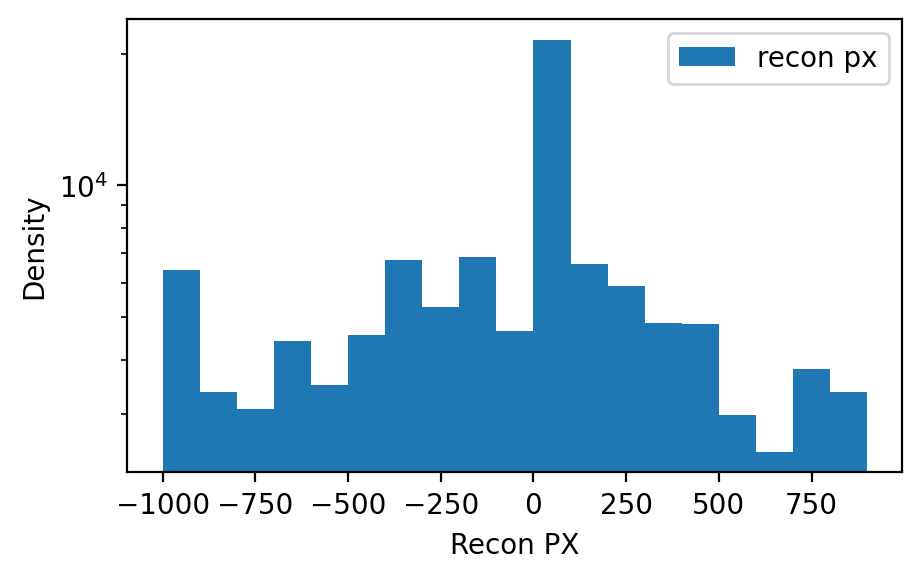

In [29]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the x_momentum
ax.hist(recon_px, label='recon px',bins = np.arange(-1000, 1000, 100))
ax.set_xlabel('Recon PX')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [30]:
filtered_truth_px = [value for value in truth_ecal_px if value != -99999] # Filter out -99999 from ecal_px
min_value = min(filtered_truth_px) # Calculate the minimum and maximum values
max_value = max(filtered_truth_px)
print(f"The min: {min_value} The max: {max_value}")
print (len(truth_ecal_px))

The min: -2680.541748046875 The max: 2584.579345703125
110000


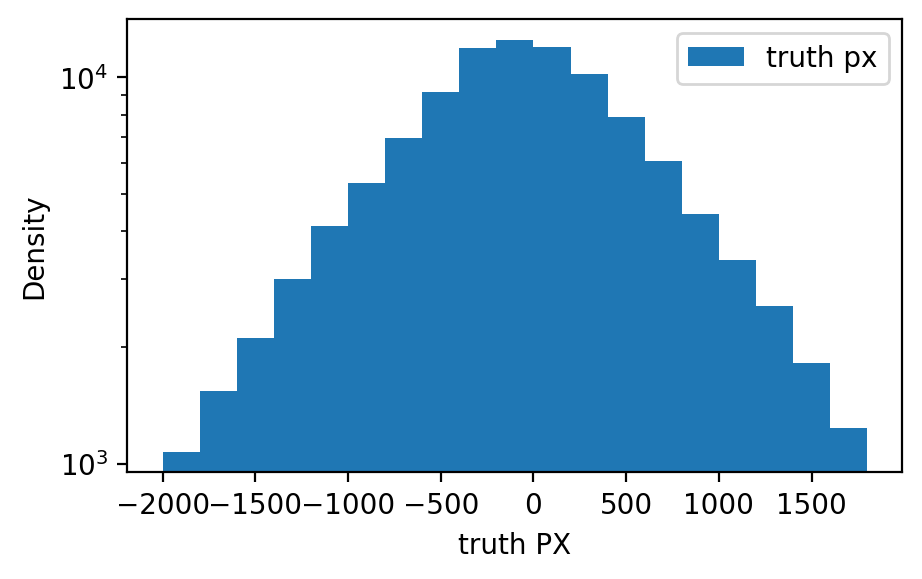

In [31]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the x_momentum
ax.hist(truth_ecal_px, label='truth px',bins = np.arange(-2000, 2000, 200))
ax.set_xlabel('truth PX')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [32]:
residual_px = recon_px - truth_ecal_px
filtered_residual_px = [value for value in residual_px if value > -90000] # Filter out -99999 from residual_px
min_value = min(filtered_residual_px) # Calculate the minimum and maximum values
max_value = max(filtered_residual_px)
print(f"The min: {min_value} The max: {max_value}")

The min: -2584.579345703125 The max: 2680.541748046875


In [33]:
print(len(residual_px))

110000


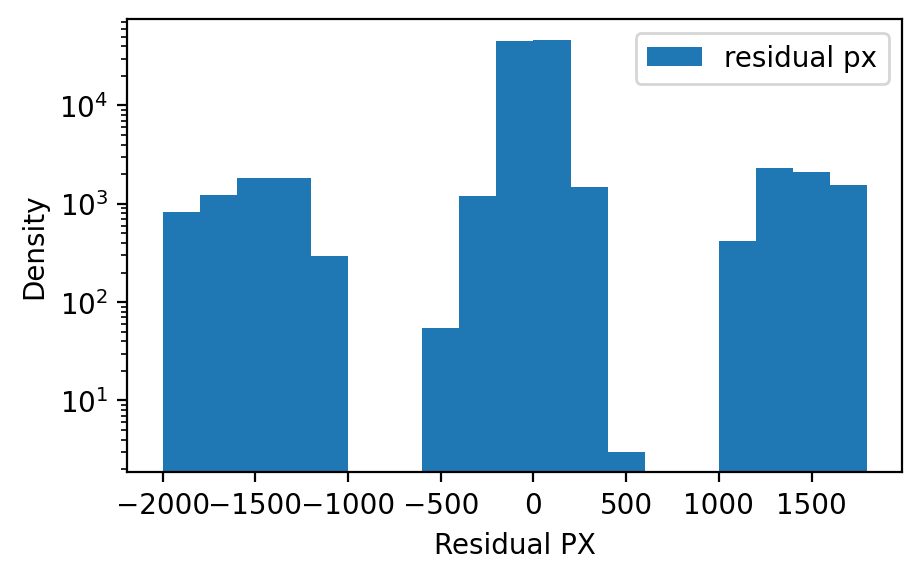

In [34]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the x_momentum
ax.hist(residual_px, label='residual px',bins = np.arange(-2000, 2000, 200))
ax.set_xlabel('Residual PX')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [35]:
print(len(truth_dy_array))

11


In [36]:
dy_h3 = hist.Hist( # For plotting dy 3D histogram
    hist.axis.Regular(20, -100, 100, name="truth_dy"),
    hist.axis.Regular(20, -1000, 1000, name="truth_ecal_py"),
    hist.axis.Regular(10, 0, 8000, name="truth_ecal_E"),
)
for i in range(len(truth_dy_array)):
    dy_h3.fill(
        truth_dy = truth_dy_array[i],
        truth_ecal_py = to_flat(ecal_electron_array[i].py),
        truth_ecal_E = to_flat(ecal_electron_array[i].energy)
)

In [37]:
dy_weights =  np.zeros((20, 10))
for dy_bin in range(20):
    for E_bin in range(10):
        # Calculate the weight for this bin using the get_mean function
        dy_weight = get_mean(dy_h3[dy_bin, :, E_bin])
        dy_weights[dy_bin, E_bin] = dy_weight

In [38]:
def get_y_weight(value, e_value):
    tmp = 0 # indexes to return
    tmp2 = 0
    condition = (value < -100) | (value > 100) | (e_value < 0) | (e_value > 8000) # Out of bound index
    
    if np.any(condition):
        return -99999 # Default value for out of bound
    for i in range(len(dx_bins)): # Loop through dx bins and compare each index to the value passed
        if value > dx_bins[i]:
            tmp = i
        else:
            break
    for j in range(len(ex_bins)): # Loop through energy bins and compare each index to the value passed
        if e_value > ex_bins[j]:
            tmp2 = j
        else:
            break
    tmp = min(tmp, len(dy_weights) - 1) # Keep tmp and tmp2 within the index of weights array
    tmp2 = min(tmp2, len(dy_weights[0]) - 1)

    return dy_weights[tmp][tmp2] # Return the value based on the value of temp(s)

In [39]:
recon_py= []
for i in range (110000):
    tmp = get_y_weight(truth_dy[i], truth_ecal_E[i])
    recon_py.append(tmp)
#recon_py

[-648.0,
 172.28637413394918,
 529.8941798941798,
 900.78125,
 621.7436974789916,
 0.0,
 284.03041825095056,
 -799.0566037735849,
 -910.1001669449082,
 738.6509635974304,
 -273.90776699029124,
 49.49748743718596,
 -226.59574468085106,
 -950.0,
 -320.01254705144294,
 -175.26817640047676,
 82.28454172366624,
 -903.7074148296593,
 -63.43283582089552,
 621.7436974789916,
 397.64764764764766,
 0.0,
 274.546553808948,
 457.58620689655174,
 0.0,
 0.0,
 0.0,
 226.31901840490798,
 172.28637413394918,
 511.1597374179431,
 124.22969187675072,
 0.0,
 -285.36082474226805,
 284.25837320574163,
 -950.0,
 -214.2052565707134,
 -108.68613138686132,
 -447.40394600207685,
 -510.7181719260065,
 -510.7181719260065,
 -83.0390920554855,
 795.8139534883721,
 909.6153846153846,
 0.0,
 -515.1648351648352,
 48.800000000000026,
 324.869109947644,
 719.0058479532164,
 778.4931506849315,
 0.0,
 50.00000000000003,
 -903.7074148296593,
 49.447513812154725,
 -947.9166666666666,
 0.0,
 950.0,
 -101.79856115107914,
 226.

In [40]:
filtered_recon_py = [value for value in recon_py if value != -99999] # Filter out -99999 from recon_py
min_value = min(filtered_recon_py) # Calculate the minimum and maximum values
max_value = max(filtered_recon_py)
print(f"The min: {min_value} The max: {max_value}")

The min: -950.0 The max: 950.0


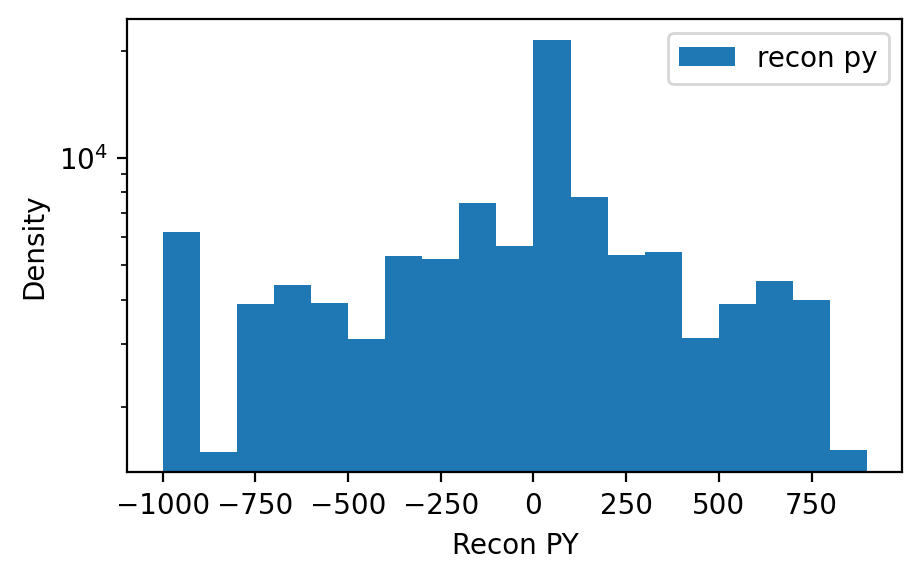

In [41]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the x_momentum
ax.hist(recon_py, label='recon py',bins = np.arange(-1000, 1000, 100))
ax.set_xlabel('Recon PY')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [42]:
truth_ecal_py = to_flat(ecal_truth_electrons.py)
filtered_truth_py = [value for value in truth_ecal_py if value != -99999] # Filter out -99999 from ecal_py
min_value = min(filtered_truth_py) # Calculate the minimum and maximum values
max_value = max(filtered_truth_py)
print(f"The min: {min_value} The max: {max_value}")

The min: -2587.94189453125 The max: 2622.24169921875


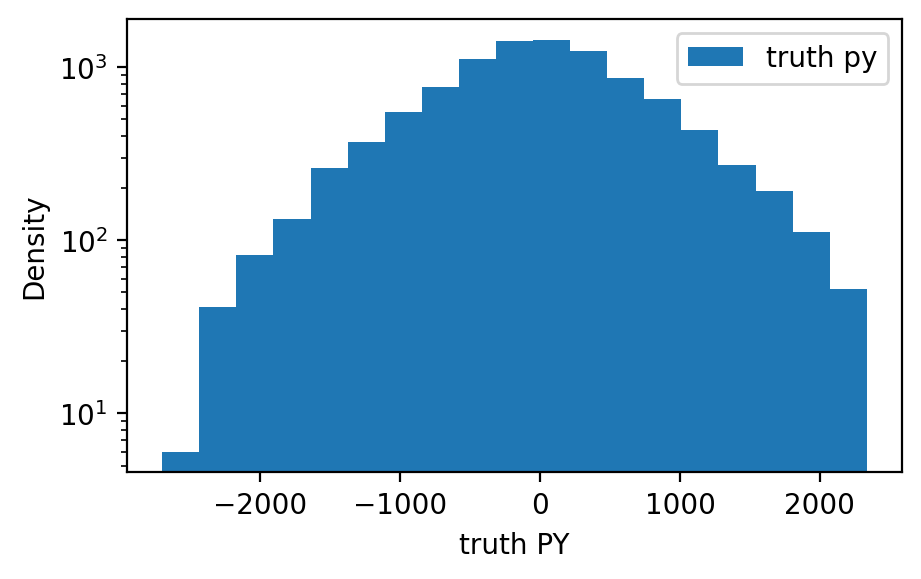

In [43]:
fig, ax = plt.subplots(figsize = (5,3), dpi= 200) # Plot the y_momentum
ax.hist(truth_ecal_py, label='truth py',bins = np.arange(-2700, 2600, 265))
ax.set_xlabel('truth PY')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [44]:
truth_pt_h = hist.Hist( # For plotting dy 3D histogram
    hist.axis.Regular(20, 0, 3000, name="truth_pt"),
)
for i in range(len(truth_dy_array)):
    truth_pt_h.fill(
        truth_pt = to_flat(ecal_electron_array[i].pt),
)

In [45]:
truth_pt_h.project("truth_pt")

Hist(Regular(20, 0, 3000, name='truth_pt'), storage=Double()) # Sum: 109864.0 (110000.0 with flow)

In [46]:
truth_pt = ak.ravel(truth_pt_array)

In [47]:
print(np.shape(truth_pt_array))

(11, 10000)


In [48]:
filtered_truth_pt = [value for value in truth_pt if value != -99999] # Filter out -99999 from ecal_py
min_value = min(filtered_truth_pt) # Calculate the minimum and maximum values
max_value = max(filtered_truth_pt)
print(f"The min: {min_value} The max: {max_value}")

The min: 1.510132908821106 The max: 2720.19384765625


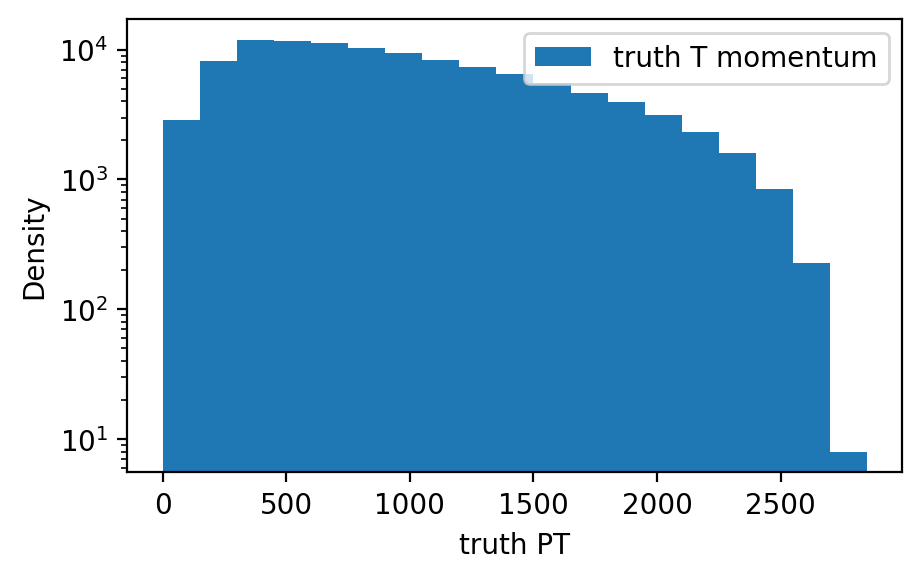

In [49]:
fig, ax = plt.subplots(figsize = (5,3), dpi = 200)
ax.hist (truth_pt, label = 'truth T momentum', bins = np.arange(0, 3000, 150))
ax.set_xlabel('truth PT')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [50]:
recon_pt =  np.hypot( # Get the hypotenuse of recon px and recon py
    recon_px, 
    recon_py
)

In [51]:
filtered_recon_pt = [value for value in recon_pt if value != -99999] # Filter out -99999 from ecal_py
min_value = min(filtered_recon_pt) # Calculate the minimum and maximum values
max_value = max(filtered_recon_pt)
print(f"The min: {min_value} The max: {max_value}")

The min: 0.0 The max: 141419.94202374713


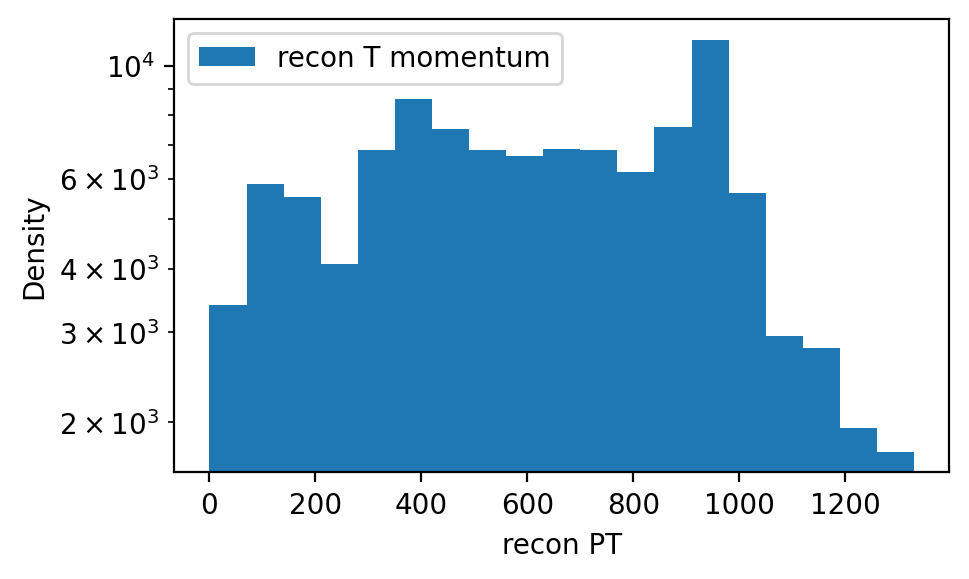

In [60]:
fig, ax = plt.subplots(figsize = (5,3), dpi = 200)
ax.hist (recon_pt, label = 'recon T momentum', bins = np.arange(0, 1400, 70))
ax.set_xlabel('recon PT')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [61]:
residual_pt = truth_pt - recon_pt

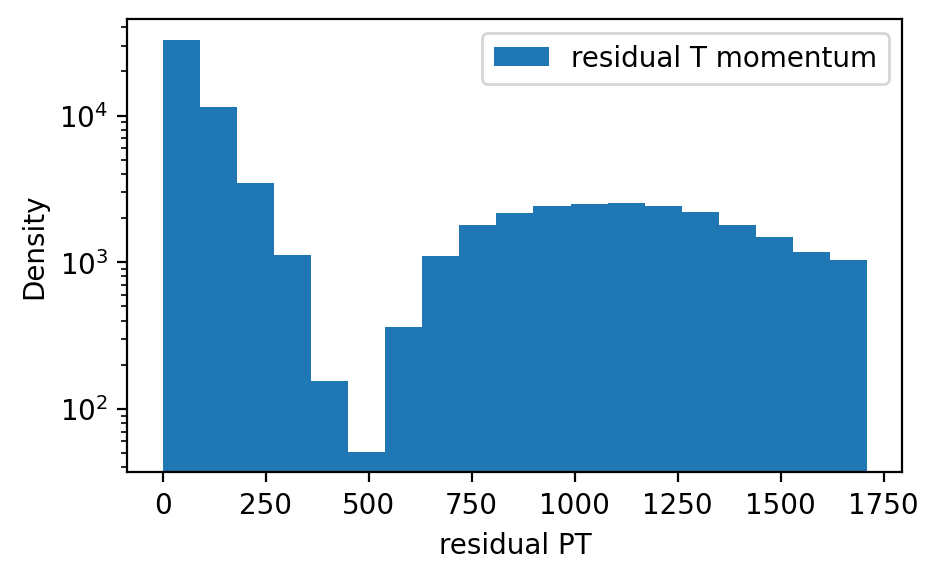

In [62]:
fig, ax = plt.subplots(figsize = (5,3), dpi = 200)
ax.hist (residual_pt, label = 'residual T momentum', bins = np.arange(0, 1800, 90))
ax.set_xlabel('residual PT')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()